In [1]:
import numpy as np
import pickle
import pandas as pd
import os
from os.path import join
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from scipy import stats
import xgboost as xgb
from hyperopt import fmin, rand, hp, Trials,tpe
# rstate = np.random.default_rng(42)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl

datasets_dir = "../../data"
# plt.style.use('CCB_plot_style_0v4.mplstyle')
# c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   # fetch the defined color styles
# high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000']

## Loading training and test data:

In [2]:
split = "secondary"

data_train = pd.read_pickle(join(datasets_dir, "splits", split, "training_data.pkl"))
data_test = pd.read_pickle(join(datasets_dir, "splits", split, "test_data.pkl"))
data_val = pd.read_pickle(join(datasets_dir, "splits", split, "val_data.pkl"))

# data_train["geomean_kcat"] = np.log10(data_train["geomean_kcat"])
# data_test["geomean_kcat"] = np.log10(data_test["geomean_kcat"])

data_train["log10_kcat"] = np.log10(data_train["kcat"])
data_test["log10_kcat"] = np.log10(data_test["kcat"])
data_val["log10_kcat"] = np.log10(data_val["kcat"])

data_train.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_test.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_val.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)

data_train['Temperature'] = data_train['Temperature'].replace('-', np.nan)
data_test['Temperature'] = data_test['Temperature'].replace('-', np.nan)
data_val['Temperature'] = data_val['Temperature'].replace('-', np.nan)
data_train['pH'] = data_train['pH'].replace('-', np.nan)
data_test['pH'] = data_test['pH'].replace('-', np.nan)
data_val['pH'] = data_val['pH'].replace('-', np.nan)
data_train['Type'] = data_train['Type'].replace('wildtype', 1)
data_train['Type'] = data_train['Type'].replace('mutant', 2)
data_test['Type'] = data_test['Type'].replace('wildtype', 1)
data_test['Type'] = data_test['Type'].replace('mutant', 2)
data_val['Type'] = data_val['Type'].replace('wildtype', 1)
data_val['Type'] = data_val['Type'].replace('mutant', 2)

data_train['MACCS FP'] = data_train['MACCS FP'].astype(str)
data_test['MACCS FP'] = data_test['MACCS FP'].astype(str)
data_val['MACCS FP'] = data_val['MACCS FP'].astype(str)

len(data_train), len(data_test), len(data_val)

(125, 41, 7)

In [3]:
train_indices = list(np.load(join(datasets_dir, "splits", split, "CV_train_indices_Seed plants.npy"), allow_pickle = True))
test_indices = list(np.load(join(datasets_dir, "splits", split, "CV_test_indices_Seed plants.npy"), allow_pickle = True))

In [4]:
data_test = data_test[~data_test['GNN FP'].isnull()]

nan_rows = data_train[data_train['GNN FP'].apply(lambda x: not isinstance(x, np.ndarray))]

# Get the indices of these rows
indices_with_nan = nan_rows.index.tolist()
# indices_with_nan.reverse()
print(indices_with_nan)

for ind, sub_list in enumerate(train_indices):
    for elem in sub_list:
        if elem in indices_with_nan:
            sub_list.remove(elem)

for ind, sub_list in enumerate(train_indices):
    for num in indices_with_nan:
        train_indices[ind] = [elem - 1 if elem > num else elem for elem in sub_list]

for ind, sub_list in enumerate(test_indices):
    for elem in sub_list:
        if elem in indices_with_nan:
            sub_list.remove(elem)

for ind, sub_list in enumerate(test_indices):
    for num in indices_with_nan:
        test_indices[ind] = [elem - 1 if elem > num else elem for elem in sub_list]      


data_train = data_train[data_train['GNN FP'].apply(lambda x: isinstance(x, np.ndarray))]
data_train.reset_index(inplace=True, drop=True)

[]


## 1. Training a model with enzyme and substrate information (ESM-2/MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [5]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [6]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
#     "max_depth": hp.choice("max_depth", np.linspace(3,10,8)),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 11)),
#     "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 11)),
#     "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
#     "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
#     "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=tpe.suggest, max_evals = 10, trials=trials)

In [7]:
# print(best)

In [8]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4, 'max_depth': 5, 'min_child_weight': 2, 'num_rounds': 50, 'reg_alpha': 0.2, 'reg_lambda': 0.7}
elif split == "Arabidopsis":
    param = {"random_state": 42,'learning_rate': 0.04, 'max_delta_step': 3, 'max_depth': 4, 'min_child_weight': 6, 'num_rounds': 150, 'reg_alpha': 0.6, 'reg_lambda': 0.6}
elif split == "Brassicaceae":
    param = {"random_state": 42,'learning_rate': 0.05, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 2, 'num_rounds': 150, 'reg_alpha': 0.7, 'reg_lambda': 1}
elif split == "wildtype":
    param = {"random_state": 42,'learning_rate': 0.03, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 8, 'num_rounds': 100, 'reg_alpha': 0.8, 'reg_lambda': 1}
else:
    param = {"random_state": 42, 'learning_rate': 0.04, 'max_delta_step': 1, 'max_depth': 6, 'min_child_weight': 3, 'num_rounds': 200, 'reg_alpha': 0.5, 'reg_lambda': 0.3}


#### (c) Training and validating model:

In [9]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [10]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_EMS2_gnn_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_EMS2_gnn_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_EMS2_gnn_fp.npy"), np.array(R2))

[0.0014715364731261171, 0.5933471395499963, 0.17352119777485223, 0.9958862351409188, 0.9382772605525]
[107.89881435568778, 2.9140342387938754, 8.989884668837632, 15.143067266117754, 50.859618212564754]
[-0.05723184063077458, 0.351154228849346, -0.024903788259748927, 0.8443551890209073, 0.25542467589224027]
[27.192776920338808, 2.193560863235859, 6.585865783833994, 4.691150822745583, 13.027051003818164]
[2.7565780601633847, 2.0853803944798384, 4.223135603516898, 0.0667648218874211, 2.989474871659037]


In [11]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))
# MedAE = np.median(abs(np.array(test_Y) - np.array(y_test_pred)))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", "y_test_pred_xgboost_EMS2_gnn_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_EMS2_gnn_fp.npy"), test_Y)

0.276 7.5607783744 -0.05 4.0788607804 1.8155674102


In [12]:
y_test_pred_esm1b_ts_drfp = y_test_pred

In [13]:
pd.DataFrame(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))).describe()

,0
count,41.000000
mean,4.078861
std,6.445267
min,0.005395
25%,0.329940
50%,1.815567
75%,5.079522
max,34.069251


#### (d) Training model with test and train data for production mode:

In [14]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [15]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.9632730548484367, 7.069402835994646e-24) 2.349353823456906 0.8986050755958163


##### Validating model

In [16]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [17]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(0.020936658220535087, 0.9644646146424217) 4.739643691233274 -0.21675115092024488 3.8262573668453994 2.2965234484510084


## 2. Training a model with enzyme and reaction information (ESM-2/diff_fp) + Temperature + pH:

#### (a) Creating input matrices:

In [18]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [19]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))


# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
#     "max_depth": hp.choice("max_depth", np.linspace(3,10,8)),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 11)),
#     "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 11)),
#     "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
#     "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
#     "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials)

In [20]:
# print(best)

In [21]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.08, 'max_delta_step': 3, 'max_depth': 5, 'min_child_weight': 2, 'num_rounds': 100, 'reg_alpha': 0.4, 'reg_lambda': 0.5}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.07, 'max_delta_step': 1, 'max_depth': 6, 'min_child_weight': 4, 'num_rounds': 200, 'reg_alpha': 0.2, 'reg_lambda': 0.3}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.03, 'max_delta_step': 2, 'max_depth': 4, 'min_child_weight': 1, 'num_rounds': 150, 'reg_alpha': 0.7, 'reg_lambda': 0.3}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.06, 'max_delta_step': 5, 'max_depth': 3, 'min_child_weight': 2, 'num_rounds': 50, 'reg_alpha': 0.7, 'reg_lambda': 0.5}
else:
    param = {"random_state": 42, 'learning_rate': 0.04, 'max_delta_step': 1, 'max_depth': 10, 'min_child_weight': 6, 'num_rounds': 50, 'reg_alpha': 0.8, 'reg_lambda': 1}

#### (c) Training and validating model:

In [22]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [23]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_EMS2_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_EMS2_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_EMS2_diff_fp.npy"), np.array(R2))

[-0.01348164170763079, 0.5293601243152916, 0.02740454030721151, 0.7065213551151431, 0.7434850026915801]
[107.89016540301671, 3.1619370064683903, 9.656634441817323, 35.21406571946362, 54.377977813054606]
[-0.057062356253651636, 0.23606113536202655, -0.18256886446964216, 0.15833496812535064, 0.14884519716404399]
[26.958467375373647, 2.665459869473272, 7.269027459586576, 8.99460041497929, 13.222110112937983]
[1.4464873636827096, 2.805975873505879, 4.825763180013089, 0.07543974847736926, 1.7752381196230713]


In [24]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)
MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", "y_test_pred_xgboost_EMS2_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_EMS2_diff_fp.npy"), test_Y)

0.289 7.4535830029 -0.021 3.8798632011 1.51693407


In [25]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [26]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [27]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.8508432729662725, 1.8602184364322034e-12) 4.831085600224142 0.5712453687235945


##### Validating model

In [28]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [29]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(-0.17661330571408634, 0.7048261364345066) 4.911656389613935 -0.3066712351334755 4.202070930470204 4.11909089299639


## 3. Training a model with enzyme, substrate (MACCS fp) and reaction information (ESM-2/diff_fp) + Temperature + pH:

#### (a) Creating input matrices:

In [30]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [31]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
#     "max_depth": hp.choice("max_depth", np.linspace(3,10,8)),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 11)),
#     "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 11)),
#     "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
#     "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
#     "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials)

In [32]:
# print(best)

In [33]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.06, 'max_delta_step': 1, 'max_depth': 6, 'min_child_weight': 3, 'num_rounds': 200, 'reg_alpha': 1, 'reg_lambda': 0.7}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4, 'max_depth': 3, 'min_child_weight': 5, 'num_rounds': 150, 'reg_alpha': 0.5, 'reg_lambda': 0.8}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.07, 'max_delta_step': 1, 'max_depth': 3, 'min_child_weight': 5, 'num_rounds': 100, 'reg_alpha': 0.6, 'reg_lambda': 0.5}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.09, 'max_delta_step': 2, 'max_depth': 4, 'min_child_weight': 3, 'num_rounds': 100, 'reg_alpha': 0, 'reg_lambda': 0.8}
else:
    param = {"random_state": 42, 'learning_rate': 0.03, 'max_delta_step': 2, 'max_depth': 7, 'min_child_weight': 6, 'num_rounds': 150, 'reg_alpha': 0.2, 'reg_lambda': 0.4}

#### (c) Training and validating model:

In [34]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [35]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_EMS2_gnn_fp_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_EMS2_gnn_fp_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_EMS2_gnn_fp_diff_fp.npy"), np.array(R2))

[0.017239320931253133, 0.7229713576533273, -0.022883055165730914, 0.960468305914129, 0.9036363260252886]
[107.73597986693379, 3.5156761069051106, 11.724697408682694, 30.058892330707234, 52.95591294108581]
[-0.0540432253501395, 0.05556974169196205, -0.7433241421413479, 0.3867283497712726, 0.1927810163959559]
[26.95311361644233, 2.6734174602731042, 8.272724164388467, 7.399553183525053, 13.020410460907039]
[2.493359504918104, 1.8241223663097688, 5.86409871016386, 0.08400883629944075, 2.414603487573231]


In [36]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)
MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", "y_test_pred_xgboost_EMS2_gnn_fp_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_EMS2_gnn_fp_diff_fp.npy"), test_Y)

0.276 7.5374599199 -0.044 4.0228655844 1.7430006546


In [37]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [38]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [39]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.9423876118246268, 3.807843097539318e-20) 3.0306484173186985 0.8312707122440833


In [40]:
importances = bst.get_score()

In [41]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [42]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(-0.06843302369950485, 0.8840963290779402) 4.784775973130257 -0.2400340037120734 3.867034784726086 2.2903475639917956


In [43]:
data_val["Estimate kcat"] = y_val_pred

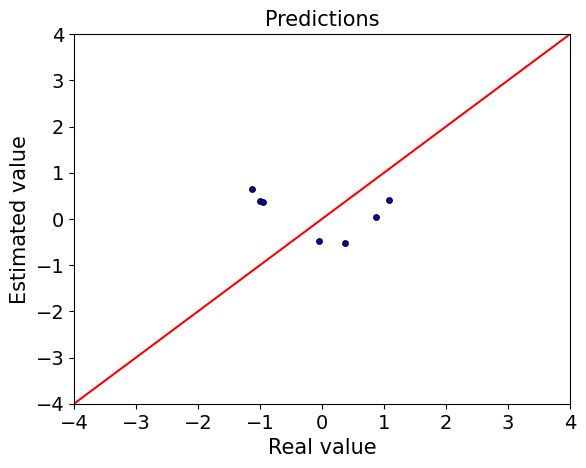

In [44]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.scatter(val_Y,y_val_pred,c='blue', edgecolors='black',s=15)
    
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Real value', fontsize=15)
plt.ylabel('Estimated value', fontsize=15)
plt.title('Predictions', fontsize=15)
plt.axline((1, 1), slope=1, c='red')
plt.show()

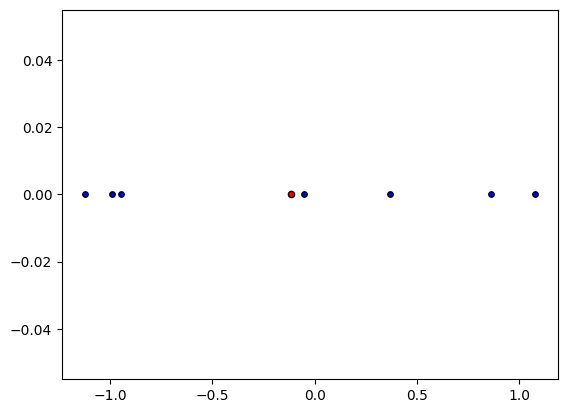

In [45]:
plt.scatter(val_Y, np.zeros_like(val_Y), c='blue', edgecolors='black',s=15)
plt.scatter(np.mean(val_Y), 0, c='red', edgecolors='black',s=20)

In [46]:
importances = bst.get_score()

In [47]:
print(len(data_train["ESM2"][1]))
print(len(data_train["difference_fp"][1]))
print(len(data_train["MACCS FP"][1]))

1280
2048
167


In [48]:
importances

{'f0': 8.0,
 'f1': 17.0,
 'f2': 2.0,
 'f3': 7.0,
 'f4': 6.0,
 'f5': 13.0,
 'f7': 2.0,
 'f8': 10.0,
 'f10': 10.0,
 'f11': 2.0,
 'f12': 32.0,
 'f13': 5.0,
 'f14': 11.0,
 'f15': 13.0,
 'f16': 1.0,
 'f21': 4.0,
 'f23': 22.0,
 'f27': 3.0,
 'f29': 2.0,
 'f30': 14.0,
 'f31': 2.0,
 'f39': 4.0,
 'f46': 1.0,
 'f48': 4.0,
 'f50': 1.0,
 'f54': 1.0,
 'f57': 1.0,
 'f59': 2.0,
 'f72': 1.0,
 'f74': 1.0,
 'f78': 6.0,
 'f80': 2.0,
 'f84': 1.0,
 'f87': 12.0,
 'f88': 1.0,
 'f89': 1.0,
 'f91': 2.0,
 'f93': 8.0,
 'f94': 3.0,
 'f95': 3.0,
 'f96': 1.0,
 'f98': 22.0,
 'f102': 4.0,
 'f104': 3.0,
 'f105': 4.0,
 'f109': 1.0,
 'f123': 4.0,
 'f124': 1.0,
 'f126': 1.0,
 'f129': 2.0,
 'f132': 24.0,
 'f133': 4.0,
 'f134': 2.0,
 'f135': 25.0,
 'f136': 1.0,
 'f137': 2.0,
 'f144': 10.0,
 'f146': 6.0,
 'f150': 1.0,
 'f156': 2.0,
 'f163': 2.0,
 'f164': 5.0,
 'f170': 6.0,
 'f173': 3.0,
 'f174': 1.0,
 'f175': 1.0,
 'f177': 3.0,
 'f195': 7.0,
 'f199': 5.0,
 'f200': 6.0,
 'f204': 4.0,
 'f205': 3.0,
 'f211': 16.0,
 'f212': 2.0,

In [49]:
# data_combined = pd.concat([data_train, data_test],ignore_index=True)


In [50]:
# plt.hist([10**x for x in data_combined["log10_kcat"]], bins=50, color='skyblue', edgecolor='black')

In [51]:
# plt.hist([10**x for x in data_val["log10_kcat"]], bins=50, color='skyblue', edgecolor='black')

In [52]:
# def calculate_identity_ignore_gaps(seq1, seq2):
#     identical_residues = sum([1 for x, y in zip(seq1, seq2) if x == y and x != "-"])
#     pid = identical_residues / sum([1 for x in seq1 if x != "-"]) 
#     return pid

# from Bio import Align
# from Bio.Align import substitution_matrices

# data_val["max_identity"] = np.nan

# aligner=Align.PairwiseAligner()
# aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
# aligner.mode = "global"
# aligner.extend_gap_score = -0.5
# aligner.open_gap_score = -10

# for i in data_val.index:
#     identities = []
#     for j in data_combined.index:
#         seq1 = str(data_val["Sequence"][i])
#         seq2 = str(data_combined["Sequence"][j])
#         if 'U' in seq1:
#             seq1 = seq1.replace('U', 'C')
#         if 'U' in seq2:
#             seq2 = seq2.replace('U', 'C')
#         alignments = aligner.align(seq1, seq2)
#         identities.append(calculate_identity_ignore_gaps(alignments[0][0], alignments[0][1]))
#     data_val["max_identity"][i] = max(identities)

In [53]:
# data_val["max_identity"] = data_val["max_identity"]*100

In [54]:
# import matplotlib.pyplot as plt
# import sklearn.metrics as sk
# import math

# fig, ax = plt.subplots(figsize= (10,8))
# plt.rcParams.update({'font.size': 28})

# splits = ["0-40%", "40-80%", "80-99%"]
# lower_bounds = [0,40,80]
# upper_bounds = [40,80,99]

# points1 = []
# points2 = []
# n_points1, n_points2 = [], []

# for i, split in enumerate(splits):

#     lb, ub = lower_bounds[i], upper_bounds[i]
    
#     help_df = data_val.loc[data_val["max_identity"]>= lb].loc[data_val["max_identity"]<= ub]
#     y_true = np.array([10**x for x in help_df["log10_kcat"]])
#     y_pred = np.array([10**x for x in help_df["Estimate kcat"]])
#     n_kcat = len(y_pred)
#     R2 =  sk.r2_score(y_true, y_pred)
#     abs_error = abs(y_true - y_pred)
#     rmse = math.sqrt(np.mean(abs(y_true - y_pred)**2))
#     print(len(y_true))
#     print(split, R2, rmse)
#     points1.append(R2)
#     points2.append(rmse)
#     n_points1.append(n_kcat)


# ticks2 = np.array(range(len(splits)))
# labs = splits
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='x', length=0, rotation = 0)

# # plt.ylim((-0.1,2.5))
# # plt.xlim((-0.2, 3.2))
# plt.legend(loc = "lower right", fontsize=20)
# plt.ylabel('RMSE')
# plt.xlabel('Enzyme sequence identity')
# # ax.yaxis.set_label_coords(-0.15, 0.5)
# # ax.xaxis.set_label_coords(0.5,-0.13)

# plt.plot([-0.15,4], [0,0], color='grey', linestyle='dashed')


# plt.plot([0,1,2], points2, c= "black", linewidth=2)

# for i, split in enumerate(splits):
#     points1.append(R2)
    
#     if i ==0:
#         plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
#         ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")

#     else:
#         plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
#         ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")
            
     
# plt.savefig(join("..","..", "data", "sequence_identity.png"))
# plt.show()

In [55]:
# EC_kcat_pred =[[] for _ in range(6)]
# EC_kcat =[[] for _ in range(6)]
# for ind in data_val.index:
#     try:
#         EC = int(data_val["ECs"][ind][0][0])
#         EC_kcat[EC-1].append(data_val["log10_kcat"][ind])
#         EC_kcat_pred[EC-1].append(data_val["Estimate kcat"][ind])
#     except IndexError:
#         pass

In [56]:
# fig, ax = plt.subplots(figsize= (8,8))
# plt.rcParams.update({'font.size': 28})

# classes = [str(i) for i in range(1,7)]

# for i in range(len(EC_kcat)):
    
#     circle = plt.Circle((np.mean(EC_kcat[i]), np.mean(EC_kcat_pred[i]) ),
#                         np.sqrt(len(EC_kcat_pred[i]))/300, color='navy', fill = True)
#     ax.add_artist(circle)
#     if i ==5:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_kcat[i])+0.01, np.mean(EC_kcat_pred[i])-0.05), fontsize=17, c='red', weight = "bold")
#     else:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_kcat[i])+0.03, np.mean(EC_kcat_pred[i])-0.01), fontsize=17, c='red', weight = "bold")
    

# ticks2 = [0.2, 0.6,1,1.4,1.8]
# labs = ticks2
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='x', length=0, rotation = 0)

# ax.set_yticks(ticks2)
# ax.set_yticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='y', length=0, rotation = 0)

# plt.ylim((0,2))
# plt.xlim((0, 2))
# plt.legend(loc = "upper left", fontsize=20)
# plt.xlabel('mean measured \n $k_{cat}$ value on $\log_{10}$-scale')
# plt.ylabel('mean predicted \n $k_{cat}$ value on $\log_{10}$-scale')
# ax.yaxis.set_label_coords(-0.15, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.13)

# plt.plot([0,2], [0,2], color='grey', alpha = 0.3, linestyle='dashed')
# plt.savefig(join("..", "..", "data", "EC_classes_mean_kcat.png"))
# plt.show()

In [57]:
# import scipy

# train_fps = [data_combined["difference_fp"][ind][:3276].reshape(1,-1).astype(int) for ind in data_combined.index]
# test_fps = [data_val["difference_fp"][ind][:3276].reshape(1,-1).astype(int) for ind in data_val.index]

# max_sim = []

# for fp in test_fps:
#     jaccard_sim = np.array([1 - scipy.spatial.distance.cdist(fp,train_fp, metric='jaccard')[0][0] for train_fp in train_fps])
#     max_sim.append(np.max(jaccard_sim))
    
# data_val["reaction_sim"] = max_sim

# data_val["reaction_sim"]= (data_val["reaction_sim"] - np.min(data_val["reaction_sim"]))
# data_val["reaction_sim"] = data_val["reaction_sim"]/np.max(data_val["reaction_sim"])

In [58]:
# train_fps = [np.array(list(data_combined["MACCS FP"][ind])).reshape(1,-1) for ind in data_combined.index]
# test_fps = [np.array(list(data_val["MACCS FP"][ind])).reshape(1,-1) for ind in data_val.index]

# max_sim = []

# for fp in test_fps:
#     jaccard_sim = np.array([1 - scipy.spatial.distance.cdist(fp,train_fp, metric='jaccard')[0][0] for train_fp in train_fps])
#     max_sim.append(np.max(jaccard_sim))
    
# data_val["substrate_sim"] = max_sim

# data_val["substrate_sim"]= (data_val["substrate_sim"] - np.min(data_val["substrate_sim"]))
# data_val["substrate_sim"] = data_val["substrate_sim"]/np.max(data_val["substrate_sim"])

In [59]:
# data_val["global_sim"] = (data_val["max_identity"]/100)*data_val["reaction_sim"]*data_val["substrate_sim"]

In [60]:
# data_val.describe()

In [61]:
# import matplotlib.pyplot as plt
# import math
# import scipy as sci
# help_df = data_val

# sim_bins_lb = [0.0, 0.4, 0.8]
# sim_bins_ub = [0.4, 0.8, 1]
# r2_scores, n_points, pearson_r, rmse = [], [], [], []
# for i in range(len(sim_bins_lb)):
#     help_df2 = help_df.loc[help_df["global_sim"] <= sim_bins_ub[i]].loc[help_df["global_sim"] >= sim_bins_lb[i]]
#     pred = np.array([10**x for x in help_df2["log10_kcat"]])
#     true = np.array([10**x for x in help_df2["Estimate kcat"]])
#     r2_scores.append(sk.r2_score(true, pred))
#     pearson_r.append(sci.stats.pearsonr(true, pred)[0])
#     rmse.append(math.sqrt(np.mean(abs(true - pred)**2)))
#     n_points.append(len(pred))
#     print("%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]), r2_scores[-1], pearson_r[-1], rmse[-1], len(pred))
    

# plt.rcParams.update({'font.size': 24})

# fig, ax = plt.subplots(figsize= (8,6))

# for i in range(len(sim_bins_lb)):    
#     plt.scatter(i, rmse[i], c='navy', marker="o", linewidths= 8)
#     ax.annotate(n_points[i], (i-0.08, rmse[i]+0.05), fontsize=17, c= "black", weight = "bold")

    
# plt.xlabel('Reaction similarity score')
# plt.ylabel('RMSE')
# ax.yaxis.set_label_coords(-0.2, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.23)

# ticks2 = np.array(range(len(sim_bins_lb)))
# labs = ["%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]) for i in range(len(sim_bins_lb))]
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=20)
# ax.tick_params(axis='x', length=0, rotation = 0)

# # plt.ylim((0.5,2))
# #plt.xlim((-0.5, 3.2))

# # plt.plot([-0.49, 4], [0,0], color='grey', linestyle='dashed')
# #plt.savefig(join("..","..", "data", "figures", "Reaction_Similarity_Score.eps"))
# plt.show()

## 4. Training a model with enzyme information (ESM-2) + Temperature + pH:

#### (a) Creating input matrices:

In [62]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [63]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))


# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
#     "max_depth": hp.choice("max_depth", np.linspace(3,10,8)),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 11)),
#     "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 11)),
#     "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
#     "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
#     "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials)

In [64]:
# print(best)

In [65]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.09, 'max_delta_step': 1, 'max_depth': 3, 'min_child_weight': 2, 'num_rounds': 200, 'reg_alpha': 0.6, 'reg_lambda': 0.6}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.03, 'max_delta_step': 2, 'max_depth': 5, 'min_child_weight': 1, 'num_rounds': 100, 'reg_alpha': 0.5, 'reg_lambda': 0.4}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.05, 'max_delta_step': 5, 'max_depth': 3, 'min_child_weight': 1, 'num_rounds': 100, 'reg_alpha': 0.3, 'reg_lambda': 0.3}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.06, 'max_delta_step': 4, 'max_depth': 5, 'min_child_weight': 1, 'num_rounds': 200, 'reg_alpha': 0.5, 'reg_lambda': 0.9}
else:
    param = {"random_state": 42, 'learning_rate': 0.08, 'max_delta_step': 1, 'max_depth': 5, 'min_child_weight': 4, 'num_rounds': 100, 'reg_alpha': 0.6, 'reg_lambda': 0.6}

#### (c) Training and validating model:

In [66]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [67]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_EMS2.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_EMS2.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_EMS2.npy"), np.array(R2))

[-0.017364883620061, 0.42501927640667747, 0.19196702936039736, 0.7103786069919364, 0.7005957662938144]
[107.93237909494646, 3.3222483030806895, 8.88198899986026, 32.54466754613257, 51.997853100999016]
[-0.05788970199202237, 0.15663348367847996, -0.0004498418612737254, 0.2811030811451243, 0.2217246539079124]
[27.454350031792238, 2.386411237670247, 6.6072074226934605, 9.360110946019429, 13.38744188220957]
[2.0350544136591324, 1.4791762187363218, 4.938123990411306, 0.058228001256824875, 1.7841047158716599]


In [68]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_EMS2.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_EMS2.npy"), test_Y)

0.161 8.0063217023 -0.178 4.1605399766 1.2373718834


In [69]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [70]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [71]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.8629129476709316, 4.020489233895027e-13) 3.9394831555978342 0.7148995816328725


In [72]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f0: 26.0
f1: 7.0
f2: 9.0
f3: 4.0
f4: 3.0
f5: 7.0
f6: 5.0
f7: 15.0
f8: 4.0
f9: 3.0
f10: 4.0
f11: 1.0
f12: 3.0
f13: 2.0
f14: 6.0
f15: 2.0
f16: 3.0
f17: 1.0
f18: 5.0
f19: 11.0
f20: 12.0
f21: 5.0
f23: 3.0
f24: 1.0
f25: 1.0
f27: 1.0
f30: 5.0
f31: 5.0
f32: 1.0
f37: 3.0
f39: 2.0
f41: 1.0
f44: 3.0
f45: 1.0
f54: 2.0
f55: 1.0
f62: 1.0
f65: 2.0
f69: 2.0
f70: 7.0
f71: 3.0
f74: 1.0
f75: 5.0
f78: 3.0
f83: 2.0
f90: 1.0
f92: 5.0
f93: 3.0
f98: 4.0
f99: 2.0
f104: 2.0
f105: 11.0
f107: 5.0
f109: 1.0
f111: 1.0
f114: 1.0
f121: 3.0
f122: 1.0
f125: 1.0
f127: 1.0
f131: 5.0
f132: 8.0
f136: 1.0
f137: 1.0
f138: 1.0
f142: 1.0
f144: 2.0
f152: 3.0
f153: 2.0
f154: 3.0
f163: 2.0
f167: 4.0
f170: 6.0
f177: 5.0
f179: 8.0
f181: 3.0
f182: 1.0
f184: 2.0
f186: 1.0
f189: 1.0
f195: 2.0
f199: 1.0
f204: 1.0
f210: 1.0
f212: 2.0
f220: 3.0
f224: 2.0
f233: 1.0
f235: 4.0
f236: 1.0
f237: 1.0
f242: 23.0
f243: 2.0
f251: 1.0
f254: 1.0
f256: 1.0
f259: 2.0
f270: 4.0
f275: 2.0
f276: 5.0
f278: 2.0
f290: 1.0
f294: 5.0
f301: 2.0
f302:

#### (e) Validating model:

In [73]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate kcat"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(-0.3084717773607397, 0.5008775257058903) 5.05046239132191 -0.3815692552294503 3.9406524724691283 3.9406524724691283


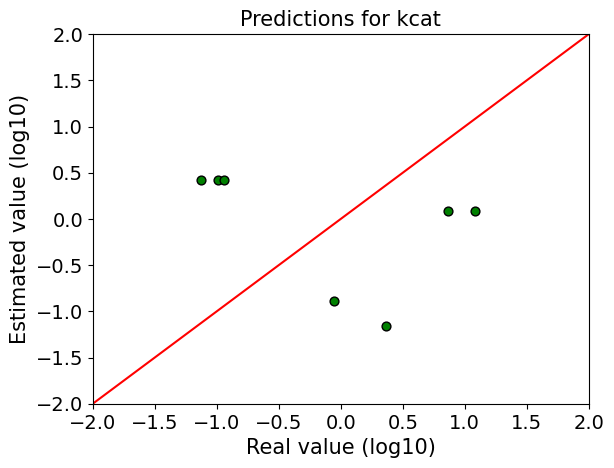

In [74]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.scatter(val_Y,y_val_pred,c='green', edgecolors='black',s=40)
    
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Real value (log10)', fontsize=15)
plt.ylabel('Estimated value (log10)', fontsize=15)
plt.title('Predictions for kcat', fontsize=15)
plt.axline((1, 1), slope=1, c='red')
plt.show()

## 5. Training a model with main substrate information (MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [75]:
train_X = np.array(list(data_train['GNN FP']))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test['GNN FP']))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [76]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))


# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
#     "max_depth": hp.choice("max_depth", np.linspace(3,10,8)),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 11)),
#     "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 11)),
#     "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
#     "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
#     "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials)

In [77]:
# print(best)

In [78]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.06, 'max_delta_step': 4, 'max_depth': 6, 'min_child_weight': 2, 'num_rounds': 100, 'reg_alpha': 0.9, 'reg_lambda': 0.8}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.02, 'max_delta_step': 1, 'max_depth': 9, 'min_child_weight': 6, 'num_rounds': 100, 'reg_alpha': 0.4, 'reg_lambda': 0.2}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.08, 'max_delta_step': 4, 'max_depth': 4, 'min_child_weight': 1, 'num_rounds': 100, 'reg_alpha': 0.7, 'reg_lambda': 0.8}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.04, 'max_delta_step': 5, 'max_depth': 6, 'min_child_weight': 3, 'num_rounds': 50, 'reg_alpha': 0, 'reg_lambda': 0.6}
else:
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3, 'max_depth': 8, 'min_child_weight': 2, 'num_rounds': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.8}

#### (c) Training and validating model:

In [79]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [80]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_gnn_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_gnn_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_gnn_fp.npy"), np.array(R2))

[0.18893889668654473, 0.13731878874239506, 0.1735742549703926, 0.9950662974562307, 0.9966189265449883]
[106.89563199488896, 5.427307014368679, 9.364338834462659, 22.5085017213516, 17.954672352704755]
[-0.037664138675270964, -1.2507173420082367, -0.1120622466584913, 0.656125384612246, 0.9072065298124936]
[26.40050838786471, 3.4530345123868815, 6.243340025463804, 5.915167617452517, 6.169583497755732]
[1.102549976135132, 2.8082566742201047, 2.628940969153679, 0.5406062911879592, 2.044051424097024]


In [81]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_gnn_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_gnn_fp.npy"), test_Y)

-0.032 8.1993334683 -0.235 4.3414290322 2.4237628991


In [82]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [83]:
train_X = np.array(list(data_train["GNN FP"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["GNN FP"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [84]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.2878006818214538, 0.06805320430618847) 7.315206166848599 0.016957034335548182


In [85]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f0: 36.0
f1: 187.0
f2: 47.0
f3: 20.0
f4: 52.0
f6: 3.0
f7: 35.0
f8: 18.0
f10: 6.0
f11: 7.0
f12: 1.0
f13: 9.0
f15: 7.0
f16: 8.0
f19: 4.0
f21: 19.0
f22: 26.0
f23: 7.0
f24: 1.0
f25: 2.0
f26: 3.0
f27: 5.0
f29: 13.0
f35: 7.0
f37: 3.0
f38: 4.0
f39: 19.0
f40: 52.0
f42: 4.0
f43: 18.0
f44: 40.0
f45: 37.0
f46: 2.0
f47: 3.0
f49: 20.0
f50: 11.0
f51: 3.0
f52: 277.0
f53: 344.0


#### (e) Validating model:

In [86]:
val_X = np.array(list(data_val["GNN FP"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate kcat"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(-0.29890305731279215, 0.5149271386587163) 5.684169302105633 -0.7500255400881854 3.884592884086939 2.4237628991439295


## 6. Training a model with reaction information (diff-fp) + Temperature + pH:

#### (a) Creating input matrices:

In [87]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [88]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
#     "max_depth": hp.choice("max_depth", np.linspace(3,10,8)),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 11)),
#     "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 11)),
#     "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
#     "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
#     "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials)

In [89]:
# print(best)

In [90]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.02, 'max_delta_step': 1, 'max_depth': 5, 'min_child_weight': 5, 'num_rounds': 200, 'reg_alpha': 0.8, 'reg_lambda': 0.1}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.03, 'max_delta_step': 2, 'max_depth': 3, 'min_child_weight': 4, 'num_rounds': 150, 'reg_alpha': 0.8, 'reg_lambda': 0.3}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.07, 'max_delta_step': 4, 'max_depth': 3, 'min_child_weight': 2, 'num_rounds': 100, 'reg_alpha': 0.4, 'reg_lambda': 0.8}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.06, 'max_delta_step': 5, 'max_depth': 5, 'min_child_weight': 6, 'num_rounds': 100, 'reg_alpha': 0.9, 'reg_lambda': 0.8}
else:
    param = {"random_state": 42, 'learning_rate': 0.04, 'max_delta_step': 3, 'max_depth': 7, 'min_child_weight': 5, 'num_rounds': 50, 'reg_alpha': 0, 'reg_lambda': 0.5}

#### (c) Training and validating model:

In [91]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [92]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_diff_fp.npy"), np.array(R2))

[0.13130850808763778, -0.12624044923904937, 0.30634782154306917, 0.7434155496973197, 0.471841066090832]
[107.52221376671007, 21.320268675668903, 9.166313666738962, 34.42157899121228, 56.81438934289437]
[-0.04986458094307378, -33.7326183788323, -0.06552657787452376, 0.19579175690520367, 0.07086432831006773]
[26.30847872930778, 12.06869799078798, 5.888166738386688, 8.984626629112332, 14.231968843484582]
[1.9770485890286724, 3.5096851769582975, 2.811898194311289, 0.053504035842008885, 2.049503930268175]


In [93]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_diff_fp.npy"), test_Y)

0.218 7.5189473237 -0.039 3.7970614583 1.0766219836


In [94]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [95]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [96]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.3777400606049306, 0.014896471875306991) 7.101321370000791 0.07360182032129803


In [97]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f4: 2.0
f5: 3.0
f6: 1.0
f7: 8.0
f10: 3.0
f11: 4.0
f13: 1.0
f22: 8.0
f28: 10.0
f43: 2.0
f61: 1.0
f71: 7.0
f75: 4.0
f95: 3.0
f115: 1.0
f116: 3.0
f124: 12.0
f138: 19.0
f158: 1.0
f161: 1.0
f190: 1.0
f191: 14.0
f201: 3.0
f224: 8.0
f232: 12.0
f246: 15.0
f311: 3.0
f312: 4.0
f334: 6.0
f377: 7.0
f513: 3.0
f571: 12.0
f648: 9.0
f649: 2.0
f682: 5.0
f711: 13.0
f776: 1.0
f798: 4.0
f823: 2.0
f836: 2.0
f837: 10.0
f844: 7.0
f862: 4.0
f910: 13.0
f944: 10.0
f967: 3.0
f1018: 1.0
f1024: 13.0
f1051: 10.0
f1074: 2.0
f1088: 13.0
f1089: 3.0
f1099: 12.0
f1105: 2.0
f1162: 6.0
f1206: 12.0
f1214: 7.0
f1230: 24.0
f1277: 1.0
f1287: 1.0
f1307: 7.0
f1310: 13.0
f1352: 10.0
f1372: 11.0
f1394: 2.0
f1401: 7.0
f1467: 15.0
f1498: 13.0
f1511: 7.0
f1669: 2.0
f1677: 12.0
f1684: 2.0
f1735: 8.0
f1740: 7.0
f1974: 24.0
f1983: 2.0
f2048: 54.0
f2049: 104.0


#### (e) Validating model:

In [98]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate kcat"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(-0.8281260668987445, 0.021393058987110764) 5.240168261583343 -0.4873077534839545 3.79483260380288 3.79483260380288


## 7. Training a model with reaction and main substrate information (diff-fp/MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [99]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [100]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))


# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
#     "max_depth": hp.choice("max_depth", np.linspace(3,10,8)),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 11)),
#     "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 11)),
#     "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
#     "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
#     "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials)

In [101]:
# print(best)

In [102]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.08, 'max_delta_step': 2, 'max_depth': 5, 'min_child_weight': 6, 'num_rounds': 200, 'reg_alpha': 0, 'reg_lambda': 0.1}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.03, 'max_delta_step': 3, 'max_depth': 5, 'min_child_weight': 6, 'num_rounds': 100, 'reg_alpha': 1, 'reg_lambda': 0}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.04, 'max_delta_step': 1, 'max_depth': 6, 'min_child_weight': 5, 'num_rounds': 150, 'reg_alpha': 0.5, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.02, 'max_delta_step': 4, 'max_depth': 10, 'min_child_weight': 4, 'num_rounds': 100, 'reg_alpha': 0.9, 'reg_lambda': 0.6}
else:
    param = {"random_state": 42, 'learning_rate': 0.08, 'max_delta_step': 5, 'max_depth': 10, 'min_child_weight': 3, 'num_rounds': 150, 'reg_alpha': 1, 'reg_lambda': 0.3}

#### (c) Training and validating model:

In [103]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [104]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(R2))

[0.0653472968653259, 0.472192020989577, 0.11345901119558452, 0.9934290755272537, 0.989744873607288]
[107.639879232614, 3.3002251816834076, 9.449698849991734, 5.271770465481521, 36.07042002199537]
[-0.052163648157961706, 0.16777774478265584, -0.13242850990382715, 0.9811366019705683, 0.6254887684119852]
[26.119914201201276, 2.41853900793844, 6.277033947381484, 2.510251514153711, 9.631720528563719]
[1.0481559654340036, 2.145990006559398, 2.6648215775893447, 0.06720040895536844, 1.9924519902396922]


In [105]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_gnn_fp_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_gnn_fp_diff_fp.npy"), test_Y)

0.108 7.8031544126 -0.119 4.0597457136 1.3300479813


In [106]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [107]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X,  np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [108]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.42649045556179577, 0.00542589127203545) 6.906658633766827 0.12369489574301618


In [109]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f4: 21.0
f5: 1.0
f6: 3.0
f7: 1.0
f11: 17.0
f23: 2.0
f28: 26.0
f31: 6.0
f43: 20.0
f52: 10.0
f61: 1.0
f74: 1.0
f75: 37.0
f94: 9.0
f95: 12.0
f106: 5.0
f111: 1.0
f116: 32.0
f124: 12.0
f125: 16.0
f137: 9.0
f138: 14.0
f139: 1.0
f157: 1.0
f158: 9.0
f159: 1.0
f178: 8.0
f181: 1.0
f190: 1.0
f191: 34.0
f194: 2.0
f195: 7.0
f200: 3.0
f201: 21.0
f202: 1.0
f233: 3.0
f246: 3.0
f254: 4.0
f255: 4.0
f270: 2.0
f311: 2.0
f312: 18.0
f334: 5.0
f377: 11.0
f413: 1.0
f431: 8.0
f563: 3.0
f570: 6.0
f571: 8.0
f648: 8.0
f682: 4.0
f706: 6.0
f711: 2.0
f728: 6.0
f756: 30.0
f776: 3.0
f778: 14.0
f780: 1.0
f783: 1.0
f798: 22.0
f818: 1.0
f834: 11.0
f836: 11.0
f837: 3.0
f844: 4.0
f847: 2.0
f883: 8.0
f909: 18.0
f910: 5.0
f953: 1.0
f967: 5.0
f1009: 2.0
f1010: 1.0
f1018: 4.0
f1024: 11.0
f1025: 3.0
f1049: 17.0
f1051: 13.0
f1074: 3.0
f1088: 10.0
f1089: 1.0
f1091: 10.0
f1097: 1.0
f1099: 9.0
f1104: 12.0
f1105: 1.0
f1112: 1.0
f1162: 2.0
f1214: 22.0
f1230: 10.0
f1276: 10.0
f1285: 1.0
f1292: 3.0
f1293: 3.0
f1310: 24.0
f1333

#### (e) Validating model:

In [110]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X,  np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate kcat"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(0.5434616148229964, 0.20736826410395937) 4.480616666528345 -0.08739155838640311 2.7392305731704583 2.7392305731704583
